<sub>Felix Becker, Lars Gabriel University of Greifswald, Germany</sub>
# Solutions to Exercise Set 2 - 1: A simple neural network for bike rentals

We will now create a simple neural network that predicts rental counts based on different attributes as defined in the first exercise (matrix $X$).

We will also learn how to optimize relevant hyperparameters of the model without underestimating the true test error.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Task 1: Preparations

Shuffle with `np.random.shuffle` and split X and y into ``X_train``, ``X_test``, ``y_train`` and ``y_test``.

In [2]:
np.random.seed(0) # so we all get the same pseudorandom results, do not modify or remove this line!

#load X and y
X = np.load("solutions/X.npy")
y = np.load("solutions/y.npy")


m,n = X.shape

#split into train and test
test_split = 0.1
#YOUR CODE STARTS

#shuffle X and y (attention, shuffle them together, i.e. keep the one-one correspondance of rows of X and values in y)
#split X and y by keeping the first (test_split*100)% examples for testing. Use the rest for training.
#Name the splitted values X_train, X_test, y_train and y_test.
perm = np.arange(m)
np.random.shuffle(perm)

k = int(m*test_split)
X_test = X[perm[:k]]
X_train = X[perm[k:]]
y_test = y[perm[:k]]
y_train = y[perm[k:]]

#YOUR CODE ENDS

## Task 2: Model search

0. Run all cells until Task 3 as they are (without adding your own code yet). This trains a linear regression (i.e. a neural network without hidden layers) as a baseline model.
1. Create a small neural network with hidden layers of various sizes and an activation function of your choice.
2. Add a L2 regularizer with ``kernel_regularizer=tf.keras.regularizers.L2(l2)`` to each Dense layer you create.
3. After training, note down *validation* error, come back here, change some hyperparameters and train again. Iterate as much as you like. Also adapt the l2 loss strength to a value > 0.
4. Report (as a group) the final *test* error of the best model and its configuration. Who wins? What is the improvement with respect to the baseline model (linear regression)?

In [3]:
tf.random.set_seed(0) # so we all get the same pseudorandom results, do not modify or remove this line!

l2 = 1e-2 #strength of l2 regularization for all kernels

def make_model():
    # a neural network is a stack of layers, in keras called "Sequential" model
    model = tf.keras.models.Sequential() # so far the stack is empty, 0 layers

    #YOUR CODE STARTS
    # add Dense neural network layers with number of hidden neurons, activation function of your choice.
    # add a L2 regularizer for each layer
    model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(l2)))
    model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(l2)))
    model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(l2)))
    #YOUR CODE ENDS
    
    #last layer maps to output size 1 and has no activation function
    model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(l2)))
    
    return model

model = make_model()

In addition to our loss (MSE) we use the **Root Mean Squared Error** as a metric.

$RMSE(\theta) = \sqrt(MSE(\theta))$

It can be interpreted as the average distance of our prediction to the true value.

A **metric** is (in constrast to a **loss**) not used for model optimization but for evaluation.

In [4]:
def fit_model(model, X_train, y_train, epochs=200, learning_rate = 0.01):
    # define the loss, optimization algorithm and prepare the model for gradient computation 
    opti = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam is a popular method for stochastic gradient descent
    model.compile(optimizer = opti, loss = "mse", metrics = [tf.keras.metrics.RootMeanSquaredError()]) 
    # execute the actual training 
    val_split = 0.15
    history = model.fit(X_train, y_train, epochs = epochs, batch_size=64, validation_split=val_split, verbose = 0) 
    return history

In [5]:
#takes ~1min
#a larger batch size can speed this up, however it can negatively affect the outcome since fewer training steps are made
#the same is true for smaller numbers of epochs
history = fit_model(model, X_train, y_train) 

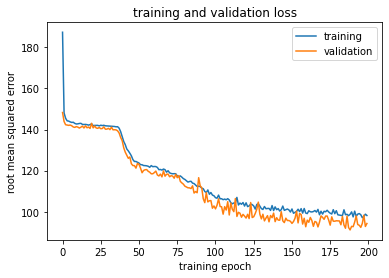

In [6]:
fig, ax= plt.subplots(1,1)
def plot_hist(history, ax, title):
    ax.plot(history.history["root_mean_squared_error"], label="training") 
    ax.plot(history.history["val_root_mean_squared_error"], label="validation") 
    ax.set_title(title)
    ax.set_xlabel("training epoch")
    ax.set_ylabel("root mean squared error")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
plot_hist(history, ax, "training and validation loss")

In [7]:
print("val mse=", history.history["val_root_mean_squared_error"][-1])

val mse= 94.30145263671875


In [8]:
#compute test error
l = model.evaluate(X_test, y_test)
print("test mse, rmse=", l)

34/34 [==============================] - 0s 703us/step - loss: 10197.3428 - root_mean_squared_error: 100.9111
test mse, rmse= [10197.3427734375, 100.91107177734375]


In [9]:
print("predictions =\t", model.predict(X_test).flatten().astype(np.int32))
print("truth =\t\t", y_test)

predictions =	 [247 261 263 ...  94  16 100]
truth =		 [244 239 229 ... 103   1  39]


Iterate at least until you have a lower validation rmse than with the linear regression baseline.

## Task 3: Transfer learning

We now have a well working neural network architecture and a trained ``model`` at hand. Naturally, as a black box, we can hardly tell anything about the inner workings of the neural network, i.e. we see that a prediction is good, but can't tell why.

However, we expect the inner layers of the neural network to learn *something* about the semantics of the problem space at hand.

To see this, assume we now have a different training target that is related to the original one. The dataset contains a "registered" column that counts only those rentals, with a registration (club membership). "registered" is similar to count, but not the same because it misses casual rentals. Maybe we can expect casual rentals to be higher in summer and spring and expect registered members to use the service more regularily over the year. 

*Question: Can we use the hidden features of the already trained model for "count" to train a model for "registered"?*

To answer this, you will train two models in the following: 
1. ``model1`` is identical to the original model except the last layer (Dense(1))
2. ``model2`` is completely new

To achieve this, use the trained ``model`` from previous cells and access its layer list with ``model.layers``. Reuse these layers for the new model (``.add``) and remember to leave out the last layer. Replace it with a new one and also apply L2 regularization to it.

Use ``fit_model`` to train both models on ``y_registered_train`` and try fewer epochs (e.g. 200) for model1 as it already has trained hidden features.

Name the two return values of ``fit_model`` ``history1`` and `history2``.

How does the loss curve change?

In [10]:
y_registered = pd.read_csv("bikes-summerdays-full.csv", sep = ";")["registered"]
y_registered_train = y_registered[perm[k:]]
y_registered_test = y_registered[perm[:k]]

In [23]:
#YOUR CODE STARTS
#construct model1 and model2 as described above, train them and name the results history1 and history2
model1 = tf.keras.models.Sequential()
for layer in model.layers[:-1]: 
    model1.add(layer)
#model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu)) #you could also add a new hidden layer on top of the previous model
model1.add(tf.keras.layers.Dense(1))

model2 = make_model()

history1 = fit_model(model1, X_train, y_registered_train, epochs=40) #fewer epochs!
history2 = fit_model(model2, X_train, y_registered_train)
#YOUR CODE ENDS

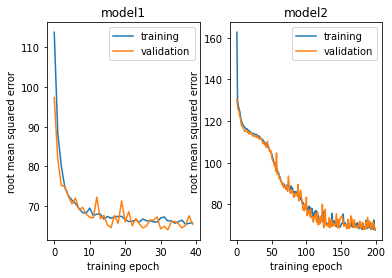

In [24]:
fig, axes = plt.subplots(1,2)
plot_hist(history1, axes[0], "model1")
plot_hist(history2, axes[1], "model2")

In [25]:
print("test mse 1=", model1.evaluate(X_test, y_registered_test, verbose=0))
print("test mse 2=", model2.evaluate(X_test, y_registered_test, verbose=0))

test mse 1= [4810.44287109375, 69.09984588623047]
test mse 2= [4810.12890625, 69.23502349853516]


$\implies$ model 1 should achieve similar test errors but training converges much faster

If `model1` performs worse than `model2`, try to transfer fewer layers. If your model architecture is more deep than broad, this might help.
Try to make the cut at a layer with many neurons. If your last hidden layer before the output layer has only 2 neurons, this might be a bottleneck that is too much tuned to the first task and not suitable for transfer learning. Also try to leave out the L2 regularizer on the new layer of `model1` as we do not need to regularize on an already pre-trained model as much.

### Improve the model search 

From here, if you want to practice off-course more or want to apply neural networks to your own data, you should consider averaging the test error over many different training-validation-test splits of the data. This is called **cross-validation** and it will trade experiment time for decreased randomness in the reported result. 